In [479]:
import torch
from torch import nn
import obspy
from obspy import read
import os
import pandas as pd
import glob
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import random
import numpy as np
import kymatio
from kymatio.torch import Scattering2D
import types
from kymatio.scattering2d.filter_bank import filter_bank, morlet_2d, gabor_2d
import pandas as pd
import torch.nn.functional as F
from tqdm import tqdm 


In [480]:
def get_time_speed(stream: obspy.core.stream.Stream):
    # all have just one trace
    trace = stream[0].resample(1)
    tr_times = trace.times()
    tr_data = trace.data

    
    return tr_times, tr_data



def zscore(input_tensor, dim=(1, 2), eps=1e-8):
    
    # Compute mean and std along the specified dimensions
    mean = torch.mean(input_tensor, dim=dim, keepdim=True)
    std = torch.std(input_tensor, dim=dim, keepdim=True)
    
    # Perform z-score normalization
    zscored_tensor = (input_tensor - mean) / (std + eps)
    
    return zscored_tensor


def sliding_window(images, window_size):
    B, H, N = images.shape
    windows = []
    for i in range(0, N - window_size + 1, window_size):  # Step size is window_size
        window = images[:, :, i:i + window_size]  # Extract a window of shape (B, 200, 200)
        windows.append(window)
    return windows

In [481]:
## Loss class 1 ############

class NTXentLoss(nn.Module):

    """Normalized Temperature-scaled Cross Entropy Loss used in SimCLR"""

    def __init__(self, device: str, batch_size: int, temperature: float, use_cosine_similarity: bool):
        super(NTXentLoss, self).__init__()
        self._batch_size = batch_size
        self._temperature = temperature
        self._device = device
        self._softmax = nn.Softmax(dim=-1)
        self._mask_samples_from_same_repr = self._get_correlated_mask().type(torch.bool)
        self._similarity_function = self._get_similarity_function(use_cosine_similarity)
        self._criterion = torch.nn.CrossEntropyLoss(reduction="sum")

    def _get_similarity_function(self, use_cosine_similarity: bool):
        if use_cosine_similarity:
            self._cosine_similarity = nn.CosineSimilarity(dim=-1)
            return self._cosine_simililarity
        else:
            return self._dot_simililarity

    def _get_correlated_mask(self) -> torch.Tensor:
        diag = np.eye(2 * self._batch_size)
        l1 = np.eye((2 * self._batch_size), 2 * self._batch_size, k=-self._batch_size)
        l2 = np.eye((2 * self._batch_size), 2 * self._batch_size, k=self._batch_size)
        mask = torch.from_numpy((diag + l1 + l2))
        mask = (1 - mask).type(torch.bool)
        return mask.to(self._device)

    @staticmethod
    def _dot_simililarity(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        v = torch.tensordot(x.unsqueeze(1), y.T.unsqueeze(0), dims=2)
        # x shape: (N, 1, C)
        # y shape: (1, C, 2N)
        # v shape: (N, 2N)
        return v

    def _cosine_simililarity(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        # x shape: (N, 1, C)
        # y shape: (1, 2N, C)
        # v shape: (N, 2N)
        v = self._cosine_similarity(x.unsqueeze(1), y.unsqueeze(0))
        return v

    def forward(self, zis: torch.Tensor, zjs: torch.Tensor) -> torch.Tensor:
        representations = torch.cat([zjs, zis], dim=0)

        similarity_matrix = self._similarity_function(representations, representations)

        # filter out the scores from the positive samples
        l_pos = torch.diag(similarity_matrix, self._batch_size)
        r_pos = torch.diag(similarity_matrix, -self._batch_size)
        positives = torch.cat([l_pos, r_pos]).view(2 * self._batch_size, 1)

        negatives = similarity_matrix[self._mask_samples_from_same_repr].view(2 * self._batch_size, -1)

        logits = torch.cat((positives, negatives), dim=1)
        logits /= self._temperature

        labels = torch.zeros(2 * self._batch_size).to(self._device).long()
        loss = self._criterion(logits, labels)


        return loss / (2 * self._batch_size)

##### LOSS CLASS 2 #######

def compute_cross_entropy(p, q):
    q = F.log_softmax(q, dim=-1)
    loss = torch.sum(p * q, dim=-1)
    return - loss.mean()


def stablize_logits(logits):
    logits_max, _ = torch.max(logits, dim=-1, keepdim=True)
    logits = logits - logits_max.detach()
    return logits


@torch.no_grad()
def concat_all_gather(tensor):
    """
    Performs all_gather operation on the provided tensors.
    *** Warning ***: torch.distributed.all_gather has no gradient.
    """
    tensors_gather = [torch.ones_like(tensor)
                      for _ in range(torch.distributed.get_world_size())]
    torch.distributed.all_gather(tensors_gather, tensor, async_op=False)

    output = torch.cat(tensors_gather, dim=0)
    return output


class MultiPosConLoss(nn.Module):
    """
    Multi-Positive Contrastive Loss: https://arxiv.org/pdf/2306.00984.pdf
    """

    def __init__(self, temperature=0.1):
        super(MultiPosConLoss, self).__init__()
        self.temperature = temperature
        self.logits_mask = None
        self.mask = None
        self.last_local_batch_size = None

    def set_temperature(self, temp=0.1):
        self.temperature = temp

    def forward(self, outputs):
        feats = outputs['feats']    # feats shape: [B, D]
        labels = outputs['labels']    # labels shape: [B]

        device = (torch.device('cuda')
                  if feats.is_cuda
                  else torch.device('cpu'))

        feats = F.normalize(feats, dim=-1, p=2)
        local_batch_size = feats.size(0)

        all_feats = torch.cat(torch.distributed.all_gather(feats), dim=0)
        all_labels = concat_all_gather(labels)  # no gradient gather

        # compute the mask based on labels
        if local_batch_size != self.last_local_batch_size:
            mask = torch.eq(labels.view(-1, 1),
                            all_labels.contiguous().view(1, -1)).float().to(device)
            self.logits_mask = torch.scatter(
                torch.ones_like(mask),
                1,
                torch.arange(mask.shape[0]).view(-1, 1).to(device) +
                local_batch_size * misc.get_rank(),
                0
            )

            self.last_local_batch_size = local_batch_size
            self.mask = mask * self.logits_mask

        mask = self.mask

        # compute logits
        logits = torch.matmul(feats, all_feats.T) / self.temperature
        logits = logits - (1 - self.logits_mask) * 1e9

        # optional: minus the largest logit to stablize logits
        logits = stablize_logits(logits)

        # compute ground-truth distribution
        p = mask / mask.sum(1, keepdim=True).clamp(min=1.0)
        loss = compute_cross_entropy(p, logits)

        return {'loss': loss, 'image_loss': loss}
    
    
#### CLASS 3 ###########
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        
        if torch.isnan(anchor_dot_contrast).any():
            print('acnhor dot nan')
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()
        
        if torch.isnan(logits).any():
            print('logits nan')
        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        if torch.isnan(exp_logits).any():
            print('exp logits nan')
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))
        if torch.isnan(log_prob).any():
            print('logits prob nan')
        

        # compute mean of log-likelihood over positive
        # modified to handle edge cases when there is no positive pair
        # for an anchor point. 
        # Edge case e.g.:- 
        # features of shape: [4,1,...]
        # labels:            [0,1,1,2]
        # loss before mean:  [nan, ..., ..., nan] 
        mask_pos_pairs = mask.sum(1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)
        print(mask_pos_pairs)
        print((mask * log_prob).sum(1) )
        
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask_pos_pairs
        if torch.isnan(mean_log_prob_pos).any():
            print('mean prob nan')

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [482]:

###############################################################################
# Implementation of parametric scattering - wavelet generation
# -----------------------------------------------------------------------------
# We wish to develop a version of the scattering transform where the wavelet
# parameters can be optimized. Currently, in Kymatio, the filter generation
# is defined using Numpy. Numpy does not give us differentiablity, so we
# reimplement the morlet generation utilizing Torch.

def morlets(grid_or_shape, theta, xis, sigmas, slants, morlet=True, ifftshift=True, fft=True, return_gabors=False):
    """Creates morlet wavelet filters from inputs

        Parameters:
            grid_or_shape -- a grid of the size of the filter or a tuple that indicates its shape
            theta -- global orientations of the wavelets
            xis -- frequency scales of the wavelets
            sigmas -- gaussian window scales of the wavelets
            slants -- slants of the wavelets
            morlet -- boolean for morlet or gabor wavelet
            ifftshift -- boolean for the ifftshift (inverse fast fourier transform shift)
            fft -- boolean for the fft (fast fourier transform)
        Returns:
            wavelets -- the wavelet filters

    """
    orientations = torch.cat((torch.cos(theta).unsqueeze(1),torch.sin(theta).unsqueeze(1)), dim =1)
    n_filters, ndim = orientations.shape

    wave_vectors = orientations * xis[:, np.newaxis]
    _, _, gauss_directions = torch.linalg.svd(orientations[:, np.newaxis])
    gauss_directions = gauss_directions / sigmas[:, np.newaxis, np.newaxis]
    indicator = torch.arange(ndim, device=slants.device) < 1
    slant_modifications = (1.0 * indicator + slants[:, np.newaxis] * ~indicator)
    gauss_directions = gauss_directions * slant_modifications[:, :, np.newaxis]
    if return_gabors:
        wavelets, gabors = raw_morlets(grid_or_shape, wave_vectors, gauss_directions, morlet=morlet,
                          ifftshift=ifftshift, fft=fft, return_gabors=True)
    else:
        wavelets = raw_morlets(grid_or_shape, wave_vectors, gauss_directions, morlet=morlet,
                          ifftshift=ifftshift, fft=fft)

    norm_factors = (2 * 3.1415 * sigmas * sigmas / slants).unsqueeze(1)

    if type(grid_or_shape) == tuple:
        norm_factors = norm_factors.expand([n_filters,grid_or_shape[0]]).unsqueeze(2).repeat(1,1,grid_or_shape[1])
    else:
        norm_factors = norm_factors.expand([n_filters,grid_or_shape.shape[1]]).unsqueeze(2).repeat(1,1,grid_or_shape.shape[2])

    wavelets = wavelets / norm_factors
    if return_gabors:
      return gabors/norm_factors

    return wavelets


def raw_morlets(grid_or_shape, wave_vectors, gaussian_bases, morlet=True, ifftshift=True, fft=True, return_gabors=False):
    """ Helper function for creating morlet filters

        Parameters:
            grid_or_shape -- a grid of the size of the filter or a tuple that indicates its shape
            wave_vectors -- directions of the wave part of the morlet wavelet
            gaussian_bases -- bases of the gaussian part of the morlet wavelet
            morlet -- boolean for morlet or gabor wavelet
            ifftshift -- boolean for the ifftshift (inverse fast fourier transform shift)
            fft -- boolean for the fft (fast fourier transform)
        Returns:
            filters -- the wavelet filters before normalization

    """
    n_filters, n_dim = wave_vectors.shape
    assert gaussian_bases.shape == (n_filters, n_dim, n_dim)

    if isinstance(grid_or_shape, tuple):
        shape = grid_or_shape
        ranges = [torch.arange(-(s // 2), -(s // 2) + s, dtype=torch.float) for s in shape]
        grid = torch.stack(torch.meshgrid(*ranges), 0)
    else:
        shape = grid_or_shape.shape[1:]
        grid = grid_or_shape

    waves = torch.exp(1.0j * torch.matmul(grid.T, wave_vectors.T).T)
    gaussian_directions = torch.matmul(grid.T, gaussian_bases.T.reshape(n_dim, n_dim * n_filters)).T
    gaussian_directions = gaussian_directions.reshape((n_dim, n_filters) + shape)
    radii = torch.norm(gaussian_directions, dim=0)
    gaussians = torch.exp(-0.5 * radii ** 2)
    signal_dims = list(range(1, n_dim + 1))
    gabors = gaussians * waves

    if morlet:
        gaussian_sums = gaussians.sum(dim=signal_dims, keepdim=True)
        gabor_sums = gabors.sum(dim=signal_dims, keepdim=True).real
        morlets = gabors - gabor_sums / gaussian_sums * gaussians
        filters = morlets
    else:
        filters = gabors
    if ifftshift:
        filters = torch.fft.ifftshift(filters, dim=signal_dims)
        gabors = torch.fft.ifftshift(gabors, dim=signal_dims)
    if fft:
        filters = torch.fft.fftn(filters, dim=signal_dims)
        gabors = torch.fft.fftn(gabors, dim=signal_dims)
    if return_gabors:
        return filters, gabors
    else:
        return filters


###############################################################################
# Implementation of parametric scattering - Updating dictionaires
# -----------------------------------------------------------------------------
# Kymatio utilizes dictionaries to store wavelets. These dictionaries are fed into
# the core scattering algorithm, where the wavelets and meta information are used
# to compute scattering coefficents.
#
# We will need to update the dictionaries prior
# to the start of training so that gradients can flow from wavelets to wavelet
# parameters, as currently the wavelets that live in the dictionaries are numpy
# arrays. Note also that every iteration of training we will update these
# dictionaries.
#
# We define a series of helper functions for this purpose.


def create_filters_params(J, L):
    """ Create reusable tight frame initialized filter parameters: orientations, xis, sigmas, sigmas

        Parameters:
            J -- scale of the scattering
            L -- number of orientation for the scattering
        Returns:
            params -- list that contains the parameters of the filters

    """
    orientations = []
    xis = []
    sigmas = []
    slants = []

    for j in range(J):
        for theta in range(L):
            sigmas.append(0.8 * 2**j)
            t = ((int(L-L/2-1)-theta) * np.pi / L)
            xis.append(3.0 / 4.0 * np.pi /2**j)
            slant = 4.0/L
            slants.append(slant)
            orientations.append(t)

    xis = torch.tensor(xis, requires_grad=True, dtype=torch.float32)
    sigmas = torch.tensor(sigmas, requires_grad=True, dtype=torch.float32)
    slants = torch.tensor(slants, requires_grad=True, dtype=torch.float32)
    orientations = torch.tensor(orientations, requires_grad=True, dtype=torch.float32)
    params = [orientations, xis, sigmas, slants]

    return  params


def update_psi(J, psi, wavelets):
    """ Update the psi dictionnary with the new wavelets

        Parameters:
            J -- scale for the scattering
            psi -- dictionnary of filters
            wavelets -- wavelet filters

        Returns:
            psi -- dictionnary of filters
    """
    wavelets = wavelets.real.contiguous().unsqueeze(3)
    for i, d in enumerate(psi):
        for c in range(len(d['levels'])):
            d['levels'][c] = periodize_filter_fft(wavelets[i].squeeze(2), c).unsqueeze(2)
    return psi




def update_wavelets_phi(J, L, phi, shape, params_filters, equivariant=False):
        """ Create wavelets and update the psi dictionnary with the new wavelets

            Parameters:
                J -- scale for the scattering
                psi -- dictionnary of filters
                shape -- shape of the scattering (scattering.M_padded, scattering.N_padded,)
                params_filters -- the parameters used to create wavelets

            Returns:
                psi -- dictionnary of filters
                wavelets -- wavelets filters
        """
        wavelets  = morlets(shape, params_filters[0], params_filters[1],
                                   params_filters[2], params_filters[3], return_gabors=True)
        phi = update_phi(J, phi, wavelets)
        return phi, wavelets


def update_phi(J, phi, wavelets):
    """ Update the psi dictionnary with the new wavelets

        Parameters:
            J -- scale for the scattering
            psi -- dictionnary of filters
            wavelets -- wavelet filters

        Returns:
            psi -- dictionnary of filters
    """
    wavelets = wavelets.real.contiguous().unsqueeze(3)
    for i in range(len(phi['levels'])):
        phi['levels'][i] = periodize_filter_fft(wavelets[0].squeeze(2), i).unsqueeze(2)
    return phi



def periodize_filter_fft(x, res):
    """ Periodize the filter in fourier space

        Parameters:
            x -- signal to periodize in Fourier
            res -- resolution to which the signal is cropped


        Returns:
            periodized -- It returns a crop version of the filter, assuming that the convolutions
                          will be done via compactly supported signals.
    """
    s1, s2 = x.shape[0], x.shape[1]
    periodized = x.reshape(2**res, s1// 2**res, 2**res, s2//2**res).mean(dim=(0,2))
    return periodized


def update_wavelets_psi(J, L, psi, shape, params_filters):
        """ Create wavelets and update the psi dictionnary with the new wavelets

            Parameters:
                J -- scale for the scattering
                psi -- dictionnary of filters
                shape -- shape of the scattering (scattering.M_padded, scattering.N_padded,)
                params_filters -- the parameters used to create wavelets

            Returns:
                psi -- dictionnary of filters
                wavelets -- wavelets filters
        """
        wavelets  = morlets(shape, params_filters[0], params_filters[1],
                                   params_filters[2], params_filters[3])
        psi = update_psi(J, psi, wavelets)
        return psi, wavelets


###############################################################################
# Implementation of parametric scattering - Parametric scattering module
# -----------------------------------------------------------------------------
# We have four considerations to take into account
#
# 1. We already have code that we can re-use; i.e. the core scattering algorithm,
# inheritance of nn.Module. Thus we inherit from Scattering2DTorch.
#
# 2. With a parametric scattering, we want to optimize our wavelet parameters,
# so we want gradients to flow from wavelets, but we dont want to optimize
# our wavelets. To solve this, we register the wavelet parameters as a nn.Parameter
# wrapped together in a nn.ParameterList, and register the wavelets as module buffers.
#
# 3. At the end of every training iteration, the wavelets in our dictionaries will
# be stale. We want to use our updated wavelet params to regenerate the wavelets
# every training iteration. We utilize a forward_hook piror to every forward pass.
#
# 4. We want to reshape our representation to be fed into a 2D Batchnorm.
# For convinence, we hook at the end of each forward pass to reshape the output.

def _register_single_filter(self, v, n):
    self.register_buffer('tensor' + str(n), v)

class ParametricScattering2D(Scattering2D):
    """
    A learnable scattering nn.module
    """

    def __init__(self, J, N, M, L=8, parametric=True):
        """Constructor for the leanable scattering nn.Module

        Creates scattering filters and adds them to the nn.parameters

        parameters:
            J -- scale of scattering (always 2 for now)
            N -- height of the input image
            M -- width of the input image
        """
        super(ParametricScattering2D, self).__init__(J=J, shape=(M, N), L=L)

        self.M_coefficient = self.shape[0]/(2**self.J)
        self.N_coefficient = self.shape[1]/(2**self.J)
        self.scatteringTrain = True

        self.n_coefficients =  L*L*J*(J-1)//2 + 1 + L*J

        self.params_filters = create_filters_params(J, L) #kymatio init

        shape = (self._M_padded, self._N_padded,)
        ranges = [torch.arange(-(s // 2), -(s // 2) + s, dtype=torch.float) for s in shape]
        grid = torch.stack(torch.meshgrid(*ranges), 0)

        self.psi, _ = update_wavelets_psi(J, L, self.psi, shape, self.params_filters)
        self.params_filters_phi = [torch.tensor([0], requires_grad=True, dtype=torch.float32), torch.tensor([0], requires_grad=True, dtype=torch.float32),
                torch.tensor([0.8 * 2**(J-1)], requires_grad=True,
                    dtype=torch.float32), torch.tensor([1.0],
                        requires_grad=True, dtype=torch.float32)]

        self.phi, _ = update_wavelets_phi(J, L, self.phi, shape, self.params_filters_phi)

        #for c,phi in enumerate(self.phi['levels']):
        #    self.phi['levels'][c] = torch.from_numpy(phi).unsqueeze(-1).cuda()


        self.register_single_filter = types.MethodType(_register_single_filter, self)
        self.register_filters()

        for i in range(0, len(self.params_filters)):
            self.params_filters[i] = nn.Parameter(self.params_filters[i])
            self.register_parameter(name='scattering_params_'+str(i), param=self.params_filters[i])
        self.params_filters = nn.ParameterList(self.params_filters)

        for i in range(0, len(self.params_filters_phi)):
            self.params_filters_phi[i] = nn.Parameter(self.params_filters_phi[i])
            self.register_parameter(name='scattering_params_phi_'+str(i), param=self.params_filters_phi[i])
        self.params_filters_phi = nn.ParameterList(self.params_filters_phi)

        self.register_buffer(name='grid', tensor=grid)

        def updateFilters_hook(self, ip):
            """Update the filters to reflect
            the new parameter values obtained from gradient descent"""
            if (self.training or self.scatteringTrain):
                phi, psi = self.load_filters()
                wavelets = morlets(self.grid,
                            self.scattering_params_0,
                            self.scattering_params_1,
                            self.scattering_params_2,
                            self.scattering_params_3)
                wavelets_phi = morlets(self.grid,
                            self.scattering_params_phi_0,
                            self.scattering_params_phi_1,
                            self.scattering_params_phi_2,
                            self.scattering_params_phi_3, return_gabors=True)
                self.psi = update_psi(self.J, psi, wavelets)
                self.phi = update_phi(self.J, phi, wavelets_phi)
                self.register_filters()
                self.scatteringTrain = self.training
        if parametric:
            self.pre_hook = self.register_forward_pre_hook(updateFilters_hook)

        def reshape_hook(self, x, S):
            S = S[:,:, -self.n_coefficients:,:,:]
            S = S.reshape(S.size(0), -1, S.size(3), S.size(4))
            return S
        self.register_forward_hook(reshape_hook)


        
class View(nn.Module):
    def __init__(self, *args):
        super(View, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(-1,*self.shape)


In [483]:
### All paths

base_dir_lunar_train = '/home/angshukdutta/Desktop/space_apps_2024_seismic_detection/data/lunar/training'
catalog_path_lunar_train = '/home/angshukdutta/Desktop/space_apps_2024_seismic_detection/data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'
data_path_lunar_train = '/home/angshukdutta/Desktop/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA'
data_path_lunar_test = '/home/angshukdutta/Desktop/space_apps_2024_seismic_detection/data/lunar/test'


base_dir_mars_train = '/home/angshukdutta/Desktop/space_apps_2024_seismic_detection/data/mars/training'
catalog_path_mars_train = '/home/angshukdutta/Desktop/space_apps_2024_seismic_detection/data/mars/training/catalogs'
data_path_mars_train = '/home/angshukdutta/Desktop/space_apps_2024_seismic_detection/data/mars/training/data'


In [485]:
base_dir_lunar_train

'/home/angshukdutta/Desktop/space_apps_2024_seismic_detection/data/lunar/training'

## Reading the lunar data 

##### Thanks @alen and @rohan for the data reading code

In [6]:
## get the base_training_data
catalog_lunar = pd.read_csv(catalog_path_lunar_train, header = 0)

catalog_lunar["arrival_time"] = pd.to_datetime(catalog_lunar["time_abs(%Y-%m-%dT%H:%M:%S.%f)"])
catalog_lunar["arrival_time_rel"] = catalog_lunar["time_rel(sec)"]

In [7]:
train_filepaths = glob.glob(os.path.join(data_path_lunar_train, '**', '*.mseed'), recursive=True)
test_filepaths =  glob.glob(os.path.join(data_path_lunar_test, '**', '*.mseed'), recursive=True)

In [529]:
#### check if all filenames can be read
for f in train_filepaths:
    try:
        read(f)
    except Exception as e:
        print(f"Error reading file {f}: {e}")

for f in test_filepaths:
    try:
        read(f)
    except Exception as e:
        print(f"Error reading file {f}: {e}")


train_streams = [read(file) for file in train_filepaths]
test_streams = [read(file) for file in test_filepaths]

train_filesnames = [Path(i).stem for i  in train_filepaths]
test_filenames = [Path(i).stem for i  in test_filepaths]



Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f6079f7fd60>>
Traceback (most recent call last):
  File "/home/angshukdutta/anaconda3/envs/space_apps/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

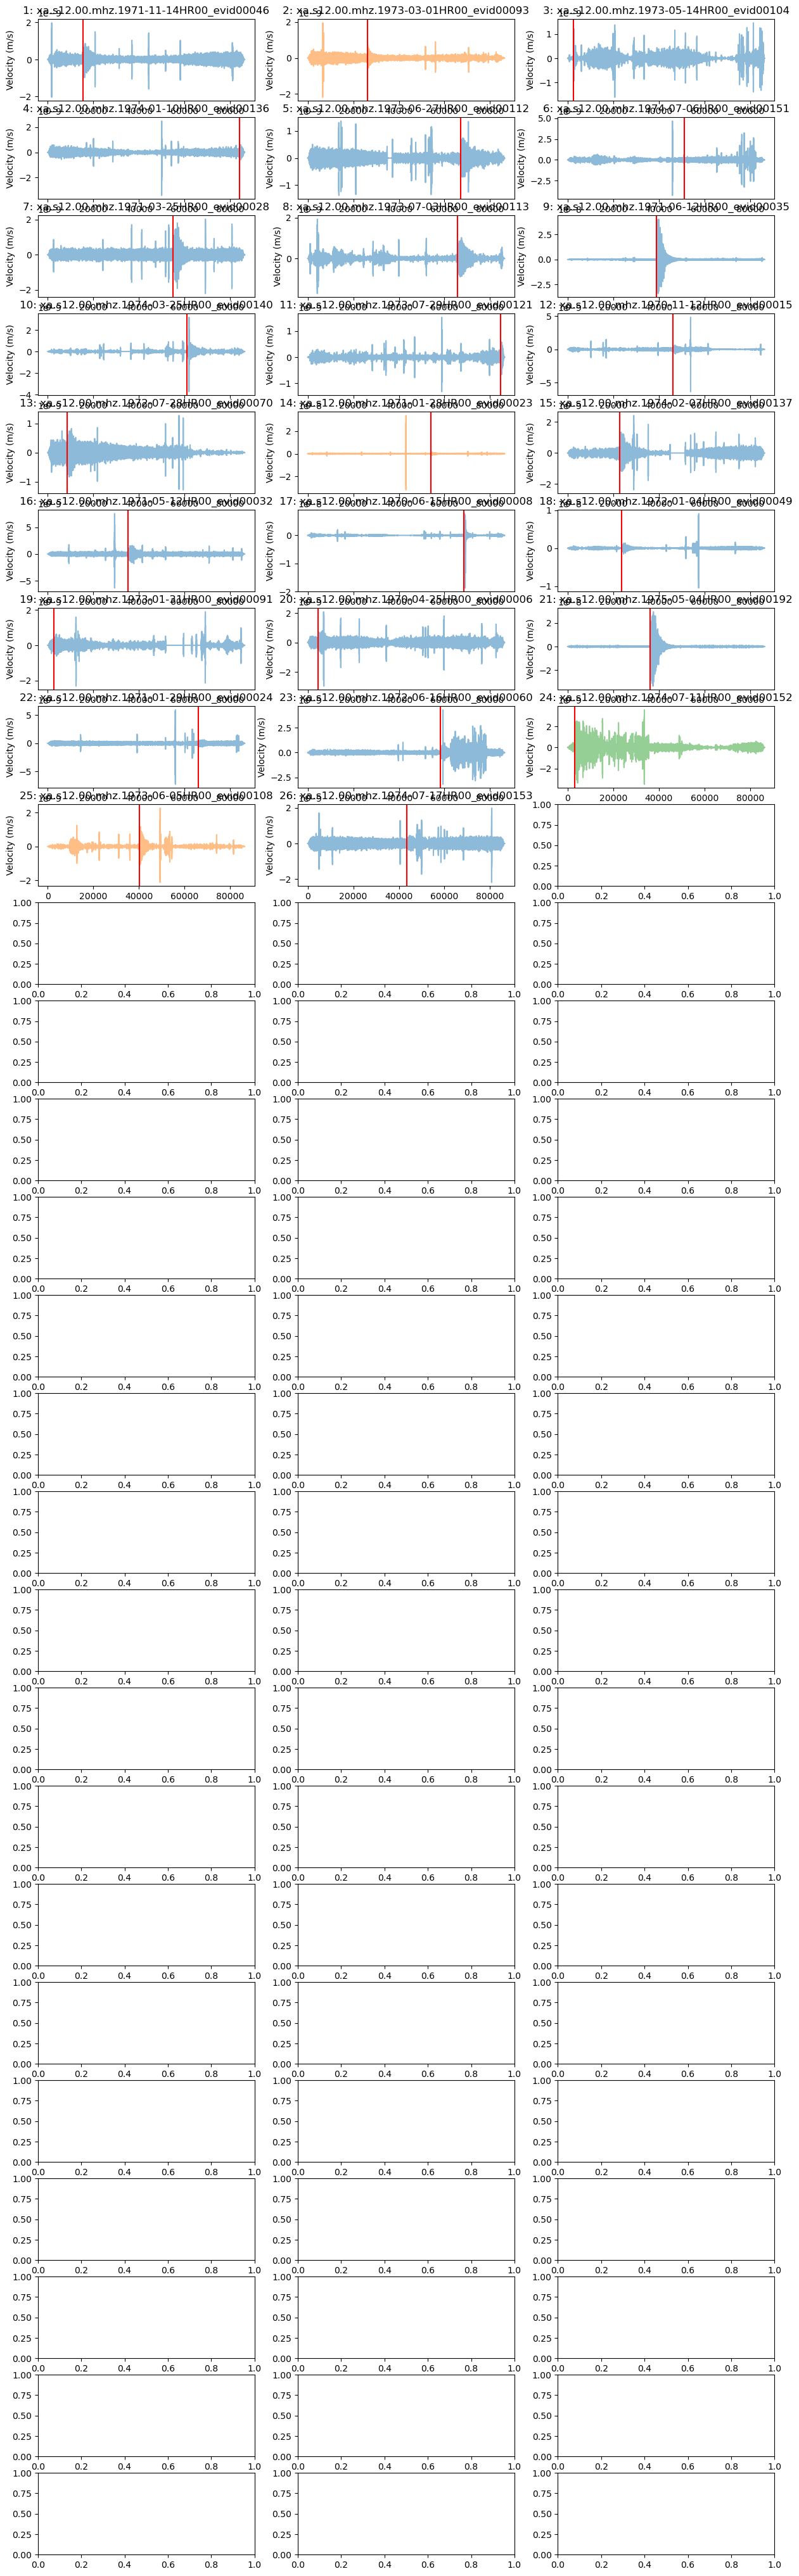

In [9]:
#### Visualise the data in relative time 
nrows = (len(train_streams) + 2) // 3
fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
axs = axs.flatten()

unique_mq_types = catalog_lunar["mq_type"].nunique()
color_map = plt.get_cmap("tab10")
color_dict = {mq: color_map(i) for i, mq in enumerate(catalog_lunar["mq_type"].unique())}

for i, stream in enumerate(train_streams):
    x, y = get_time_speed(stream)
    
    if train_filesnames[i] == 'xa.s12.00.mhz.1971-04-13HR02_evid00029':
        filename = 'xa.s12.00.mhz.1971-04-13HR00_evid00029'
    else:
        filename = train_filesnames[i]
    mq_type = catalog_lunar[catalog_lunar['filename']==filename]['mq_type']

    color = color_dict[mq_type.values[0]]
    axs[i].plot(x, y, color=color, alpha=0.5)
    axs[i].axvline(x = catalog_lunar[catalog_lunar['filename']==filename]['arrival_time_rel'].values[0], c="red")
    axs[i].set_title(f"{i+1}: {train_filesnames[i]}")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Velocity (m/s)")

for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

In [531]:
## Creating a data dictionary for both mars and moon

mq_type_list = []
velocity_array_list = []
arrival_time_list = []
seismic_dict = {}
time_list = []
for stream, filename in zip(train_streams, train_filesnames):
    t, v= get_time_speed(stream)
    
    if filename =='xa.s12.00.mhz.1971-04-13HR02_evid00029':
        filename = 'xa.s12.00.mhz.1971-04-13HR00_evid00029'
    
    mq_type = catalog_lunar[catalog_lunar['filename']==filename]['mq_type'].values[0]
    arrival_time_list.append(catalog_lunar[catalog_lunar['filename']==filename]['arrival_time_rel'].values[0])
    mq_type_list.append(mq_type)
    velocity_array_list.append(v)
    time_list.append(t)
    

seismic_dict= {
    'filename': train_filesnames,
    'velocity': velocity_array_list,
    'mq_type': mq_type_list, 
    'arrival_time': arrival_time_list, 
    'time_list': time_list
}

for stream, filename in zip(test_streams, test_filenames):
    t, v= get_time_speed(stream)
    
    if filename =='xa.s12.00.mhz.1971-04-13HR02_evid00029':
        filename = 'xa.s12.00.mhz.1971-04-13HR00_evid00029'
    
    velocity_array_list.append(v)
    time_list.append(t)
    
seismic_dict_test= {
    'filename': train_filesnames,
    'velocity': velocity_array_list,
    'time_list': time_list
}
    
    





In [532]:
seismic_dict_test

{'filename': ['xa.s12.00.mhz.1971-11-14HR00_evid00046',
  'xa.s12.00.mhz.1973-03-01HR00_evid00093',
  'xa.s12.00.mhz.1973-05-14HR00_evid00104',
  'xa.s12.00.mhz.1974-01-10HR00_evid00136',
  'xa.s12.00.mhz.1973-06-27HR00_evid00112',
  'xa.s12.00.mhz.1974-07-06HR00_evid00151',
  'xa.s12.00.mhz.1971-03-25HR00_evid00028',
  'xa.s12.00.mhz.1973-07-03HR00_evid00113',
  'xa.s12.00.mhz.1971-06-12HR00_evid00035',
  'xa.s12.00.mhz.1974-03-25HR00_evid00140',
  'xa.s12.00.mhz.1973-07-29HR00_evid00121',
  'xa.s12.00.mhz.1970-11-12HR00_evid00015',
  'xa.s12.00.mhz.1972-07-28HR00_evid00070',
  'xa.s12.00.mhz.1971-01-28HR00_evid00023',
  'xa.s12.00.mhz.1974-02-07HR00_evid00137',
  'xa.s12.00.mhz.1971-05-12HR00_evid00032',
  'xa.s12.00.mhz.1970-06-15HR00_evid00008',
  'xa.s12.00.mhz.1972-01-04HR00_evid00049',
  'xa.s12.00.mhz.1973-01-31HR00_evid00091',
  'xa.s12.00.mhz.1970-04-25HR00_evid00006',
  'xa.s12.00.mhz.1975-05-04HR00_evid00192',
  'xa.s12.00.mhz.1971-01-29HR00_evid00024',
  'xa.s12.00.mhz.197

In [10]:
df = pd.DataFrame(seismic_dict)

# Set the 'filename' column as the index
df.set_index('filename', inplace=True)

# Save the dataframe to a CSV file
csv_filename = '/home/angshukdutta/Desktop/moonquake_data.csv'
df.to_csv(csv_filename)

### Mars Data

In [499]:
cat_path_mars = '/home/angshukdutta/Desktop/space_apps_2024_seismic_detection/data/mars/training/catalogs/Mars_InSight_training_catalog_final.csv'

cat = pd.read_csv(cat_path_mars, header = 0)
cat["arrival_time"] = pd.to_datetime(cat["time_abs(%Y-%m-%dT%H:%M:%S.%f)"])
cat["arrival_time_rel"] = cat["time_rel(sec)"]


In [508]:
###### load data files 
train_path = '/home/angshukdutta/Desktop/space_apps_2024_seismic_detection/data/mars/training/data'
test_path = '/home/angshukdutta/Desktop/space_apps_2024_seismic_detection/data/mars/test/data'
train_files = glob.glob(os.path.join(train_path, '*.mseed'))
test_files = glob.glob(os.path.join(test_path, '*.mseed'))


    



In [509]:
for f in train_files:
    try:
        read(f)
    except Exception as e:
        print(f"Error reading file {f}: {e}")

for f in test_files:
    try:
        read(f)
    except Exception as e:
        print(f"Error reading file {f}: {e}")


train_streams_mars= [read(file) for file in train_files]
test_streams_mars = [read(file) for file in test_files]

train_filesnames_mars = [Path(i).stem for i  in train_files]
test_filenames_mars = [Path(i).stem for i  in test_files]


In [510]:
test_files

['/home/angshukdutta/Desktop/space_apps_2024_seismic_detection/data/mars/test/data/XB.ELYSE.02.BHV.2021-12-24HR22_evid0007.mseed',
 '/home/angshukdutta/Desktop/space_apps_2024_seismic_detection/data/mars/test/data/XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.mseed',
 '/home/angshukdutta/Desktop/space_apps_2024_seismic_detection/data/mars/test/data/XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.mseed',
 '/home/angshukdutta/Desktop/space_apps_2024_seismic_detection/data/mars/test/data/XB.ELYSE.02.BHV.2019-07-26HR12_evid0034.mseed',
 '/home/angshukdutta/Desktop/space_apps_2024_seismic_detection/data/mars/test/data/XB.ELYSE.02.BHV.2022-04-09HR22_evid0002.mseed',
 '/home/angshukdutta/Desktop/space_apps_2024_seismic_detection/data/mars/test/data/XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.mseed',
 '/home/angshukdutta/Desktop/space_apps_2024_seismic_detection/data/mars/test/data/XB.ELYSE.02.BHV.2021-05-02HR01_evid0017.mseed',
 '/home/angshukdutta/Desktop/space_apps_2024_seismic_detection/data/mars/test/data/

In [513]:
velocity_array_list_mars = []
arrival_time_list_mars = []
seismic_dict_mars = {}
time_list_mars = []


for stream, filename in zip(train_streams_mars, train_filesnames_mars):
    t, v= get_time_speed(stream)
    arrival_time_list_mars.append(cat[cat['filename']==f'{filename}.csv']['arrival_time_rel'].values[0])
    velocity_array_list_mars.append(v)
    time_list_mars.append(t)
    
seismic_dict_mars= {
    'filename': train_filesnames_mars,
    'velocity': velocity_array_list_mars,
    'arrival_time': arrival_time_list_mars, 
    'time_list': time_list_mars
}  


for stream, filename in zip(test_streams_mars, test_filenames_mars):
    t, v= get_time_speed(stream)
    velocity_array_list_mars.append(v)
    time_list_mars.append(t)
    
seismic_dict_mars_test= {
    'filename': test_filenames_mars,
    'velocity': velocity_array_list_mars,
    'time_list': time_list_mars
}  

# seismic_dict_mars['mq_type'] = ['mars']*len(seismic_dict_mars['filename'])
    



In [512]:
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,arrival_time,arrival_time_rel
0,XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.csv,2022-02-03T08:08:27.000000,507.0,evid0005,2022-02-03 08:08:27,507.0
1,XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.csv,2022-01-02T04:35:30.000000,2130.0,evid0006,2022-01-02 04:35:30,2130.0


In [ ]:
df = pd.DataFrame(seismic_dict_mars)

# Set the 'filename' column as the index
df.set_index('filename', inplace=True)

# Save the dataframe to a CSV file
csv_filename = '/home/angshukdutta/Desktop/marsquake_data.csv'
df.to_csv(csv_filename)

In [15]:
############# Make the mars and moon dict ##########################

concatenated_data_dict = {key: seismic_dict[key]+seismic_dict_mars[key] for key in seismic_dict}

In [16]:
########### Changing word labels to numbers ################
unique_mq_types = set(concatenated_data_dict['mq_type'])

mq_type_to_idx = {label: idx for idx, label in enumerate(unique_mq_types)}

# Step 2: Convert the list of words under 'mq type' into a list of integers
concatenated_data_dict['mq_type'] = [mq_type_to_idx[word] for word in concatenated_data_dict['mq_type']]


## Define a Noise Process for earth data


In [184]:
#### Defining an OU process for noise sampling 
def ornstein_uhlenbeck_noise(T, num_sequences, dt, theta=0.15, mu=0.0, sigma=0.05, x0=0.0, device='cpu'):
    noise = torch.zeros((T, num_sequences), device=device)
    noise[:, 0] = x0
    for t in range(1, T):
        noise[t, :] = noise[t-1, :] + theta * (mu - noise[t-1, :]) * dt + sigma * torch.sqrt(torch.tensor(dt, device=device)) * torch.randn(num_sequences, device=device)
    return noise

# Augmentation function for windowed time series
def augment_time_series(time_series, noise_std=0.05, device='cpu'):
    T, num_sequences = time_series.shape
    ou_noise = ornstein_uhlenbeck_noise(T, num_sequences, dt=1, sigma=noise_std, device=device)
#     noise = torch.randn(size = time_series.size()).to(device)
    noisy_series = time_series + ou_noise
    
#     Shift the time series within each window
    shift = torch.randint(1, 5, (1,), device=device).item()
    shifted_series = torch.roll(noisy_series, shifts=shift, dims=0)  # Shift along the time axis (T)

    return shifted_series

def augment_batch(time_series_batch, device='cpu'):
    augmented_batch_1 = []
    augmented_batch_2 = []
    for time_series in time_series_batch:
        augmented_batch_1.append(augment_time_series(time_series, device=device))
        augmented_batch_2.append(augment_time_series(time_series, device=device))
    
    return torch.stack(augmented_batch_1), torch.stack(augmented_batch_2)

## Model Training and Testing code

In [307]:
class Quake(Dataset):
    def __init__(self, seis_data, indices, window_len):
        
        self.vel_data = seis_data['velocity']
        self.arrival_time = seis_data['arrival_time']
        self.arrival_time_norm = seis_data['arrival_time_normalised']
        self.mq_type = seis_data['mq_type']
        self.indices = indices
        self.window_len = window_len


    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        index = self.indices[idx]
        
        time_series = self.vel_data[index]
        arrival_time = self.arrival_time[index]
        arrival_time_norm = self.arrival_time_norm[index]
        mq_type = self.mq_type[index]

        num_windows = int(np.ceil(len(time_series) / self.window_len))
        
        # Pad time_series to make its length a multiple of window_len
        pad_len = (num_windows * self.window_len) - len(time_series)
        if pad_len > 0:
            time_series = np.pad(time_series, (0, pad_len), mode='constant')
        
        # Reshape into (num_windows, window_len)
        time_series = time_series.reshape(self.window_len, num_windows)
        
        return torch.tensor(time_series), arrival_time, mq_type, arrival_time_norm

def collate_fn(batch):
    velocity_data = [i[0] for i in batch]
    arrival_time = [torch.tensor(i[1]) for i in batch]
    arrival_time_norm = [torch.tensor(i[3]) for i in batch]
    mq_type = [i[2] for i in batch]

    max_seq_len = max([x.shape[1] for x in velocity_data])
    padded_batch = []
    for time_series in velocity_data:
        seq_len = time_series.shape[1]
        if seq_len < max_seq_len:
            padding = torch.zeros(time_series.shape[0], max_seq_len - seq_len)
            padded_time_series = torch.cat((time_series, padding), dim=1)
        else:
            padded_time_series = time_series
        padded_batch.append(padded_time_series)
    
    return torch.stack(padded_batch), torch.stack(arrival_time), mq_type, torch.stack(arrival_time_norm)






In [312]:
########## Training parameters ############################
batch_size = 4
window_len = 200
epoch = 40
temp = 0.3
# Set the device based on availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 0.001
# loss = NTXentLoss(batch_size=batch_size, device = device , temperature = 0.1 , use_cosine_similarity=True)
loss = NTXentLoss(device = device, batch_size = batch_size, temperature = temp, use_cosine_similarity = True)
clip_value = 10

In [313]:
#### model loading:
K = 81
time_series_window = 200
time_series_t_seq = 200
J=2

coef_1 = time_series_window//(2**J); coef_2 = time_series_t_seq//(2**J)


model = ParametricScattering2D(J=2, M= time_series_window, N=time_series_t_seq, L = 8)
model_scattering = nn.Sequential(model, View(K, coef_1, coef_2), nn.BatchNorm2d(K), View(K * coef_1 * coef_2), nn.Linear(K*coef_1*coef_2, 200)).to(device)




In [314]:
optim = torch.optim.SGD(model_scattering.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)


In [315]:
### Dividing between train and test set:
train_indices = random.sample([i for i in range(len(concatenated_data_dict['filename']))], int(0.9*len(concatenated_data_dict['filename'])))
test_indices = set([i for i in range(len(concatenated_data_dict['filename']))]).difference(set(train_indices))

train_data_moon = Quake(concatenated_data_dict, train_indices, window_len = window_len)
test_data_moon = Quake(concatenated_data_dict, test_indices, window_len)

train_dl = DataLoader(train_data_moon, batch_size = batch_size, shuffle=True, collate_fn= collate_fn)
test_dl = DataLoader(test_data_moon, batch_size = batch_size, shuffle=True, collate_fn=collate_fn)

epoch_loss_list = []
for epoch in range(epoch):
    loss_list = []; 
    for idx, (vel_data,  arrival_time, mq_type, _) in tqdm(enumerate(train_dl), total = len(train_dl)):
        if vel_data.shape[0]!=batch_size:
            continue
        else:
            zscored_vel_data = zscore(vel_data).float()
            windowed_data = sliding_window(zscored_vel_data, window_size = 200)
            scat_coefficient_list = []
            for wind_data in windowed_data:
                augmented_data_1, augmented_data_2 = augment_batch(wind_data.to(device), device = device)   
                scat_coefficient = model_scattering(augmented_data_1.unsqueeze(1))
                scat_coefficient_2 = model_scattering(augmented_data_2.unsqueeze(1))
                loss_value = loss(scat_coefficient, scat_coefficient_2)

                optim.zero_grad()
                loss_value.backward()

                optim.step()

                loss_list.append(loss_value.cpu().detach().item())


    epoch_loss_list.append(np.nanmean(loss_list))
    print(f'epoch: {epoch}, train_loss: {epoch_loss_list[epoch]}')
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:14<00:00,  1.22it/s]


epoch: 0, train_loss: 1.2992788781138027


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.17it/s]


epoch: 1, train_loss: 0.9974982037263758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.15it/s]


epoch: 2, train_loss: 0.9294241622966879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:14<00:00,  1.22it/s]


epoch: 3, train_loss: 0.8150178553426967


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.15it/s]


epoch: 4, train_loss: 0.72461957265349


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.16it/s]


epoch: 5, train_loss: 0.6990113214534872


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:14<00:00,  1.21it/s]


epoch: 6, train_loss: 0.6542431471102378


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:14<00:00,  1.20it/s]


epoch: 7, train_loss: 0.5337917151696542


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:14<00:00,  1.24it/s]


epoch: 8, train_loss: 0.5927253505762886


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.20it/s]


epoch: 9, train_loss: 0.5940506528405582


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.15it/s]


epoch: 10, train_loss: 0.5525223757414257


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.13it/s]


epoch: 11, train_loss: 0.5621644113870228


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.19it/s]


epoch: 12, train_loss: 0.5026358011014321


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.17it/s]


epoch: 13, train_loss: 0.5109901572851574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.17it/s]


epoch: 14, train_loss: 0.4579191887203385


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.15it/s]


epoch: 15, train_loss: 0.5042474953567281


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:16<00:00,  1.10it/s]


epoch: 16, train_loss: 0.4821760566795574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.18it/s]


epoch: 17, train_loss: 0.42005856861086455


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.19it/s]


epoch: 18, train_loss: 0.4408259523265502


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:14<00:00,  1.20it/s]


epoch: 19, train_loss: 0.4051377672482939


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.20it/s]


epoch: 20, train_loss: 0.449527110247051


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:14<00:00,  1.23it/s]


epoch: 21, train_loss: 0.4021303881617153


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:16<00:00,  1.11it/s]


epoch: 22, train_loss: 0.431544988470919


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:17<00:00,  1.04it/s]


epoch: 23, train_loss: 0.4547766758238568


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.19it/s]


epoch: 24, train_loss: 0.37931522376397075


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.15it/s]


epoch: 25, train_loss: 0.4305630922317505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.13it/s]


epoch: 26, train_loss: 0.4162924925194067


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.17it/s]


epoch: 27, train_loss: 0.44615041289259405


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.18it/s]


epoch: 28, train_loss: 0.3701193871743539


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:14<00:00,  1.22it/s]


epoch: 29, train_loss: 0.38739102246130214


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.13it/s]


epoch: 30, train_loss: 0.458636516595588


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.17it/s]


epoch: 31, train_loss: 0.4162633774035117


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.18it/s]


epoch: 32, train_loss: 0.38054316841504154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.13it/s]


epoch: 33, train_loss: 0.37977871737059427


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.14it/s]


epoch: 34, train_loss: 0.3597103615894037


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.16it/s]


epoch: 35, train_loss: 0.3817396970356212


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:16<00:00,  1.12it/s]


epoch: 36, train_loss: 0.31493712172788735


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:17<00:00,  1.03it/s]


epoch: 37, train_loss: 0.37697821154313926


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:16<00:00,  1.10it/s]


epoch: 38, train_loss: 0.3766881253789453


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:15<00:00,  1.17it/s]

epoch: 39, train_loss: 0.3719827011227608


In [190]:
### SAVE the model 

path_for_model_save = './Desktop/spaceapps2024/model_contrastive.pt'
torch.save(model_scattering.state_dict(), path_for_model_save)


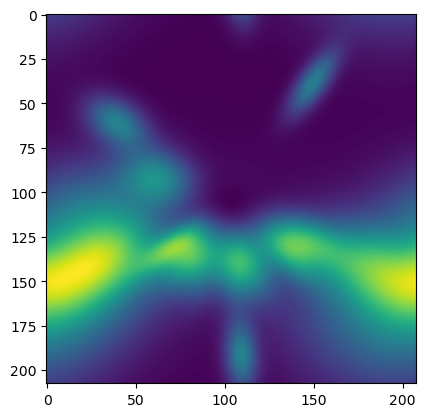

In [528]:
######### Visualise filters
def littlewood_paley_dekha(S, display=True):
    """Plots each wavelet in Fourier space, creating a
    comprehensive view of the scattering filterbank."""
    if "ParametricScattering" in type(S).__name__:
      
      wavelets = morlets(S.grid, S.params_filters[0],
                                        S.params_filters[1], S.params_filters[2],
                                          S.params_filters[3]).detach().numpy()
      gabors = morlets(S.grid, S.params_filters[0],
                                        S.params_filters[1], S.params_filters[2],
                                        S.params_filters[3], return_gabors=True).cpu().detach().numpy()
      grid = S.grid
        
        
    else:
      wavelets = []
      gabors = []
      J=S.J
      L=S.L
      M=S._M_padded
      N=S._N_padded
      shape = (M,N)
      ranges = [torch.arange(-(s // 2), -(s // 2) + s, dtype=torch.float) for s in shape]
      grid = torch.stack(torch.meshgrid(*ranges), 0).numpy()
      for j in range(J):
        for theta in range(L):
          psi_signal = morlet_2d(M, N, 0.8 * 2**j,
              (int(L-L/2-1)-theta) * np.pi / L,
              3.0 / 4.0 * np.pi /2**j, 4.0/L)
          psi_signal_fourier = np.fft.fft2(psi_signal)
          # drop the imaginary part, it is zero anyway
          psi_signal_fourier = np.real(psi_signal_fourier)
          wavelets.append(psi_signal_fourier)
          gabor = gabor_2d(M, N, 0.8 * 2**j,
              (int(L-L/2-1)-theta) * np.pi / L,
              3.0 / 4.0 * np.pi /2**j, 4.0/L)
          gabor = np.fft.fft2(np.fft.ifftshift(gabor))
          gabors.append(gabor)

      wavelets = np.asarray(wavelets)
      gabors = np.asarray(gabors)
    
    lp = (np.abs(wavelets) ** 2).sum(0)
    fig, ax = plt.subplots()

    plt.imshow(np.fft.fftshift(lp))
    plt.savefig('./Desktop/spectral_features.png', format="png", bbox_inches="tight", pad_inches=0)
#     if display:
#         grid = grid + 18
#         for i in np.abs(gabors) ** 2:
#             wave = np.fft.fftshift(i)
#             ax.contour(grid[1], grid[0], wave, 1, colors='white')
#     plt.show()

#     for idx, wave in enumerate(wavelets):
#         plt.figure()
#         plt.title(f"Wavelet Filter {idx}")
#         plt.imshow(np.abs(np.fft.fftshift(wave)), cmap='viridis')  # Convert to magnitude to handle complex values
#         plt.colorbar()
#         plt.show()

#     for idx, gabor in enumerate(gabors):
#         plt.figure()
#         plt.title(f"Gabor Filter {idx}")
#         plt.imshow(np.abs(np.fft.fftshift(gabor)), cmap='viridis')  # Convert to magnitude to handle complex values
#         plt.colorbar()
#         plt.show()


    return np.fft.fftshift(lp), wavelets

# Call the function
freq, wavelets = littlewood_paley_dekha(model_scattering[0].cpu())


In [406]:
model_scattering = model_scattering.to(device)
concatenated_data_dict['filename'][0]

'xa.s12.00.mhz.1971-11-14HR00_evid00046'

In [409]:
####### Do PCA on latent states: ###############
scat_dict = {};
for i in range(5):
    vel = concatenated_data_dict['velocity'][i]
    remainder = vel.shape[-1]%200
    reshape_value = vel.shape[-1]-remainder
#     time_to_truc = reshape_value*200
    vel_truc = vel[:reshape_value]
    
    vel_truc_reshaped = torch.tensor(vel_truc.reshape(200, reshape_value//200))
    
    windowed_vel_truc = sliding_window(vel_truc_reshaped.unsqueeze(0), 200)
    
    
    
    scat_list = []
    for k in windowed_vel_truc:
        scat_coefficient  = model_scattering[0](k.float().unsqueeze(0).contiguous().to(device))
        scat_list.append(scat_coefficient)
        
    
    scat_dict[i] = {'scat': scat_list, 
                    'wind': windowed_vel_truc}
    

    
    
        
        
        
        
        
        
        
    
    
    


In [424]:
input_signals = torch.cat((scat_dict[0]['wind']))

In [533]:

from scipy.signal import fftconvolve

def save_filter_img(input_signals, filename):
    save_path = os.path.join('/home/angshukdutta/Desktop/earth_data', f'{filename}.png')
    true_signal = input_signals.flatten().numpy()

    pad_height = (208 - input_signals.shape[1]) // 2
    pad_width = (208 - input_signals.shape[2]) // 2

    padded_signals = np.pad(input_signals, pad_width=((0, 0), (pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    # Perform FFT convolution for the entire batch and all wavelets
    responses = []
    for wavelet in wavelets:
        batch_responses = np.array([fftconvolve(padded_signal, wavelet, mode='same') for padded_signal in padded_signals])
        batch_responses = np.abs(batch_responses)  # Take the absolute value of the responses
        responses.append(batch_responses)

    # Stack responses and compute maximum response across wavelets
    responses = np.stack(responses)  
    responses = np.array(responses)
    # Shape: (num_wavelets, batch_size, height, width)
    max_responses = np.max(responses, axis=0)  # Max across wavelets, shape: (batch_size, height, width)

    # Flatten max_responses to a 1D array corresponding to the full sequence
    combined_max_response = max_responses.flatten()

    # Threshold the response to extract important regions
    threshold = 0.7 * np.max(combined_max_response)  # Set a threshold as a percentage of the max response
    important_regions = (combined_max_response > threshold)

    important_regions = important_regions[: true_signal.shape[0]]

    # Rescale important regions to match the scale of the true signal
    scaled_important_regions = important_regions * np.max(np.abs(true_signal))

    # Create a figure
    plt.figure(figsize=(12, 6))

    # Plot the true signal (1D) in blue
    plt.plot(true_signal, color='blue', linewidth=1.5, label='True Signal')

    # Add vertical lines for important regions
    for idx in np.where(important_regions)[0]:
        plt.axvspan(idx, idx + 1, color='green', alpha=0.2)  # Highlight the regions with a transparent red color

    # Add grid, labels, and title
    plt.title(f'{filename}', fontsize=16)
    plt.xlabel('Relative Time', fontsize=14)
    plt.ylabel('Signal Value', fontsize=14)
    plt.grid(True)

    # Add a legend
    plt.legend(['Quake Signal'], fontsize=12)

    # Customize ticks for better visibility
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Show the plot
#     plt.show()
                             
    plt.savefig(save_path, format="png", bbox_inches="tight", pad_inches=0)
                             
                             
                             
                             


In [ ]:
##load_model

/tmp/ipykernel_15976/398886294.py:63: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(save_path, format="png", bbox_inches="tight", pad_inches=0)
/tmp/ipykernel_15976/398886294.py:63: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(save_path, format="png", bbox_inches="tight", pad_inches=0)
/tmp/ipykernel_15976/398886294.py:63: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(save_path, format="png", bbox_inches="tight", pad_inches=0)
/tmp/ipykernel_15976/398886294.py:63: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(save_path, format="png", bbox_inches="tight", pad_inches=0)


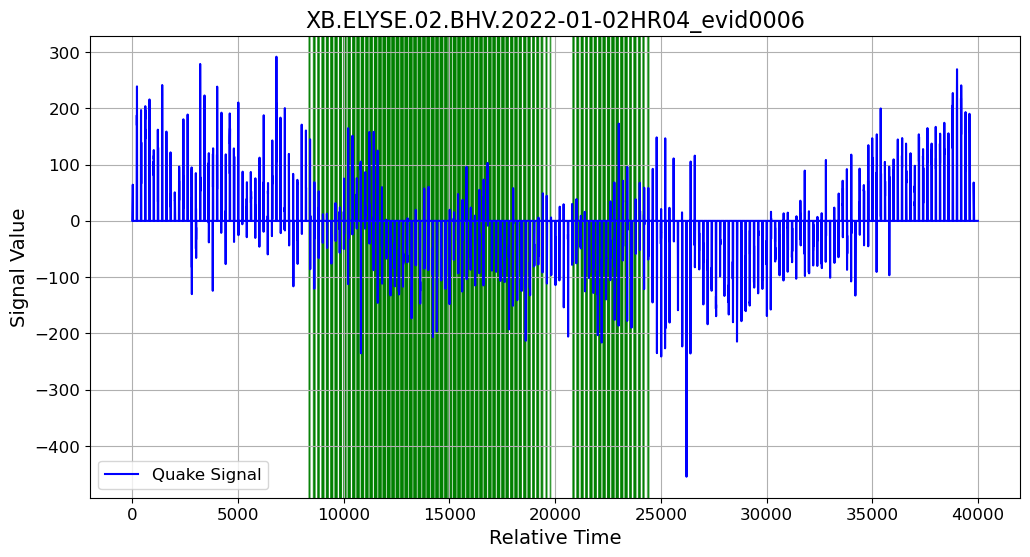

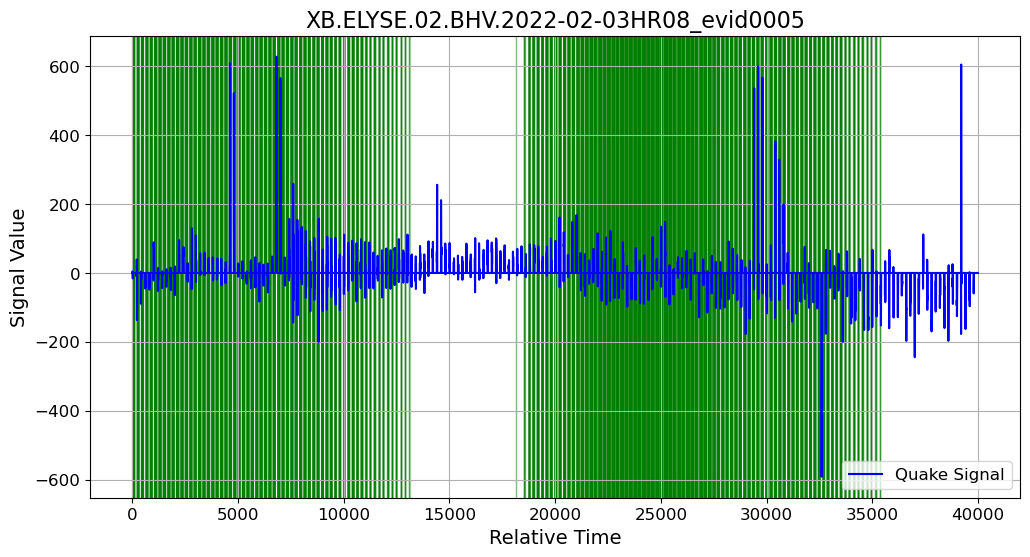

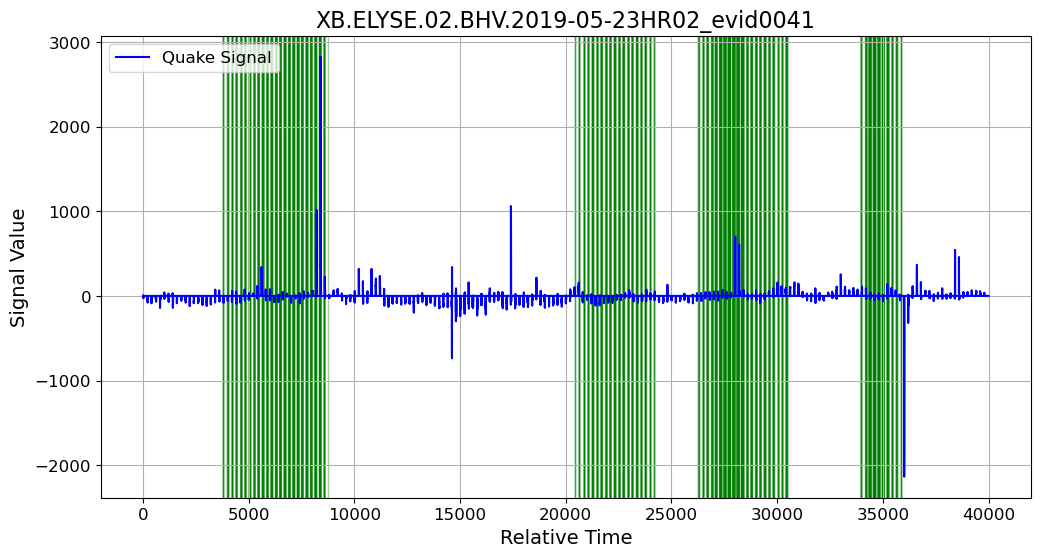

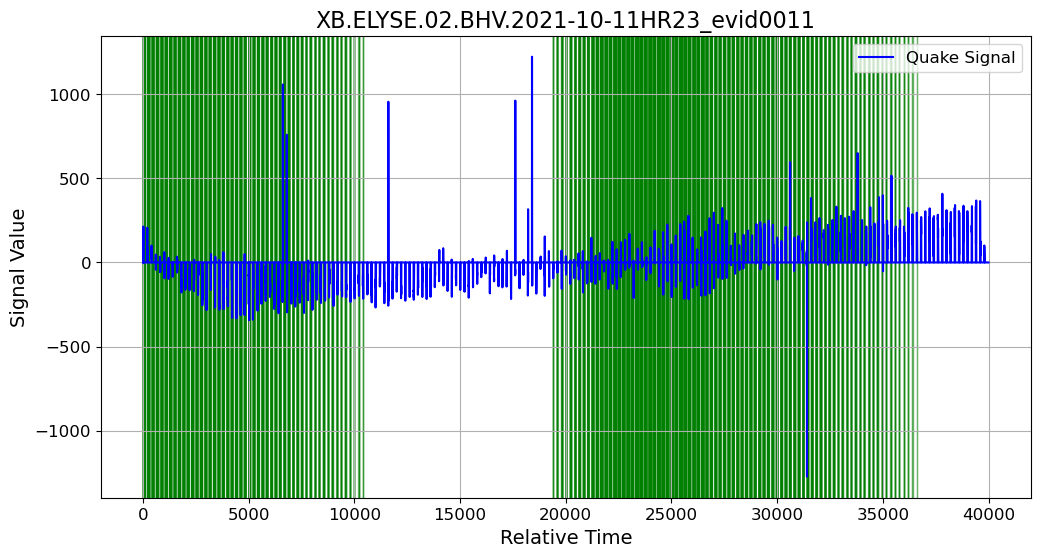

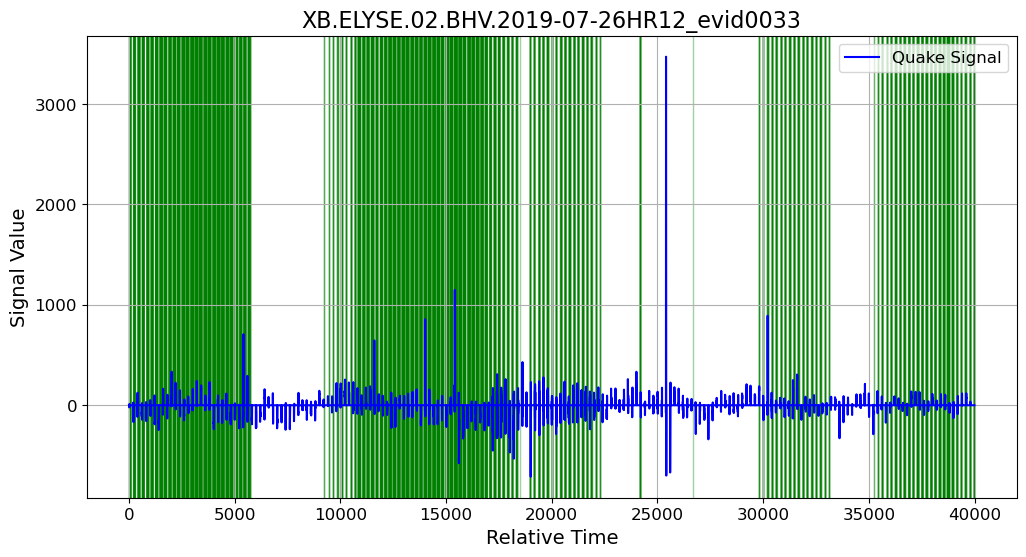

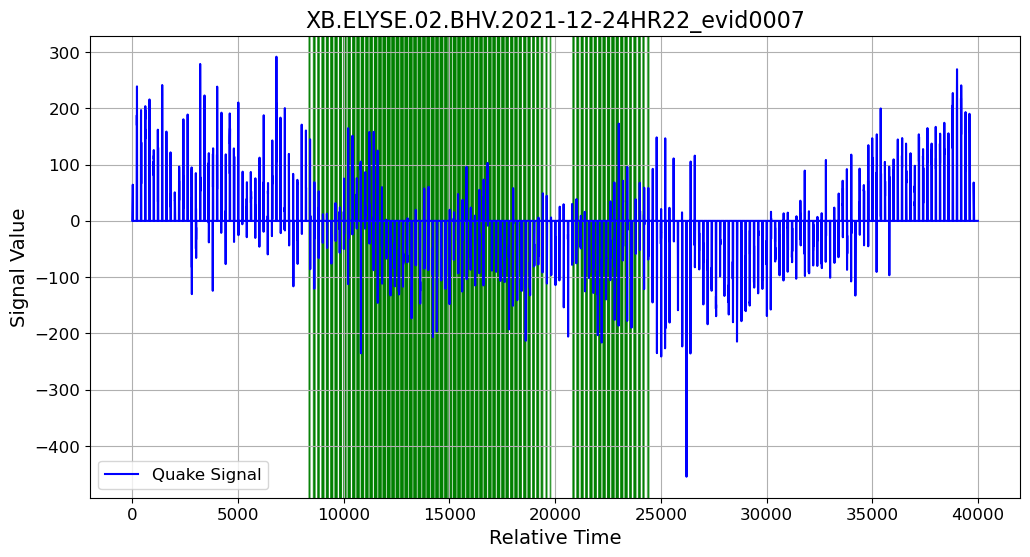

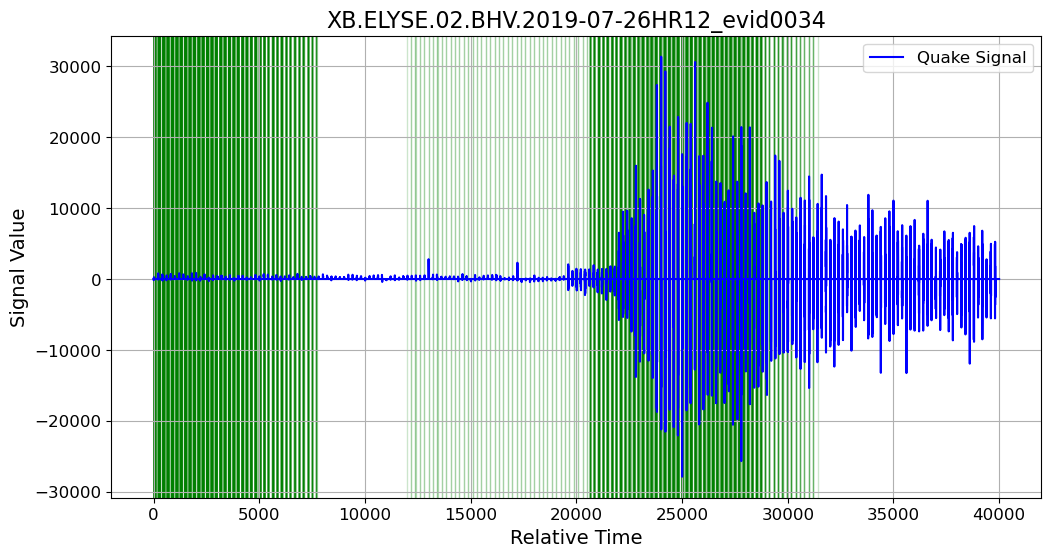

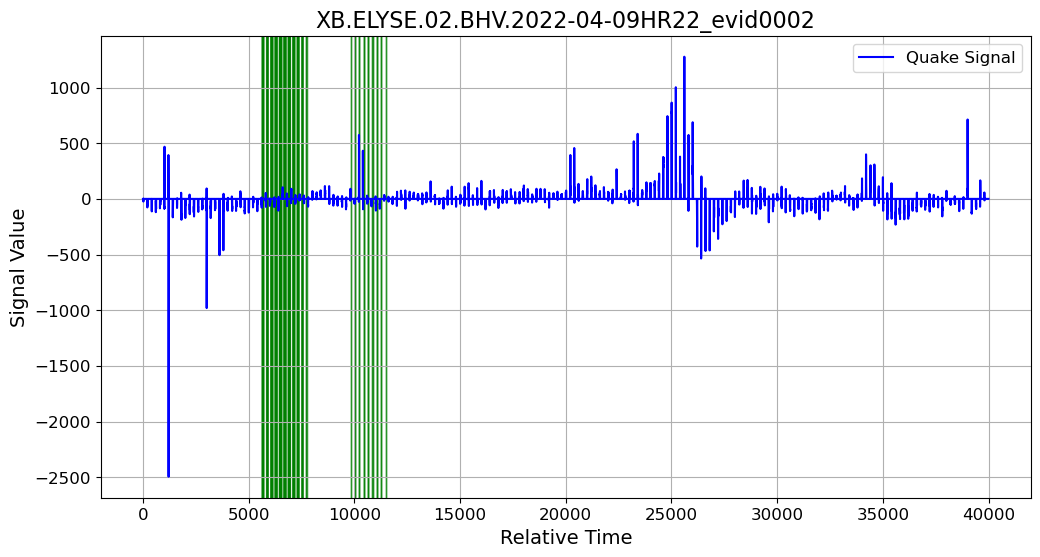

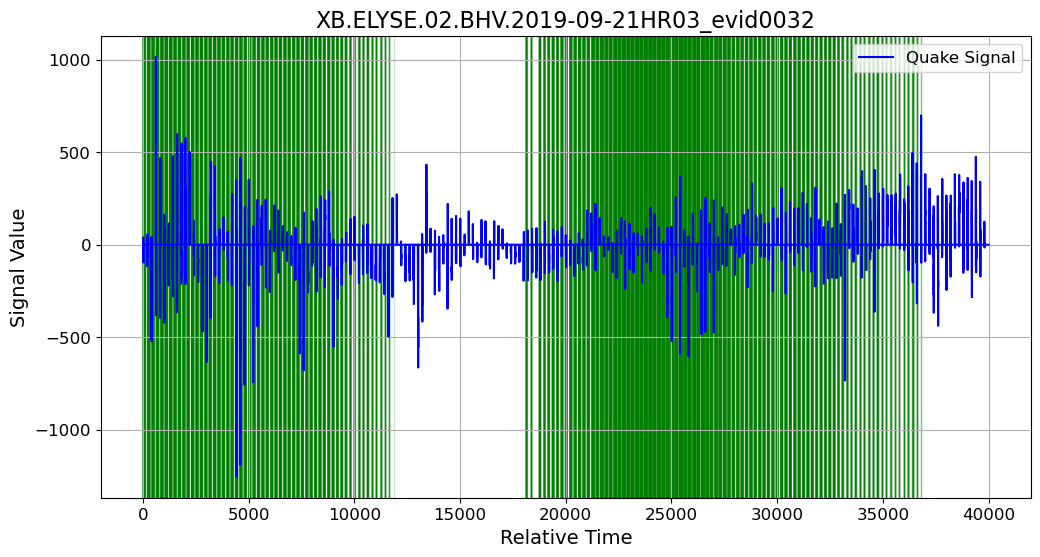

/home/angshukdutta/anaconda3/envs/space_apps/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


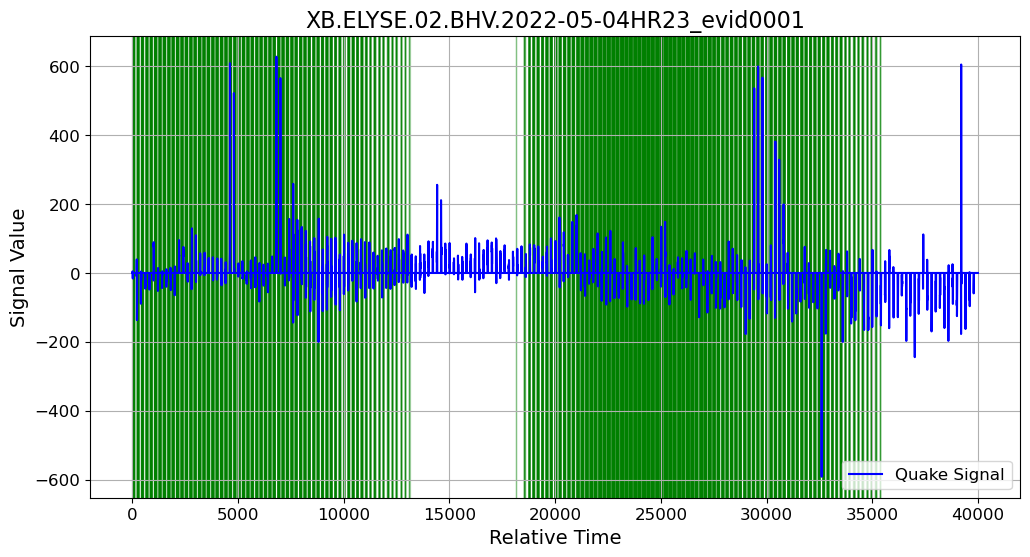

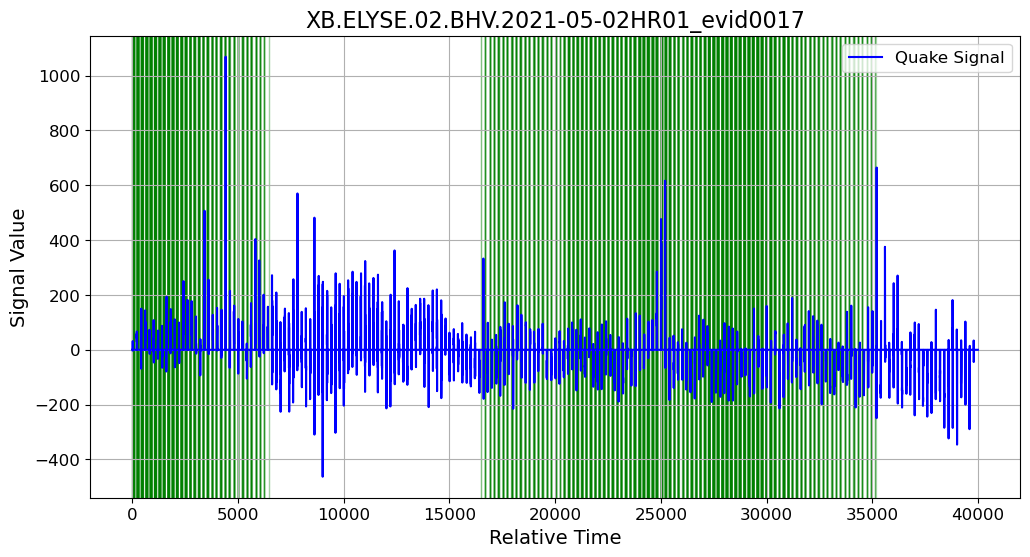

In [526]:
moon_filenames = [
  "xa.s12.00.mhz.1970-03-14HR00_evid00018",
  "xa.s12.00.mhz.1971-01-03HR00_evid00057",
 "xa.s12.00.mhz.1971-06-11HR00_evid00096",
];

# mars_filenames = [
#   "XB.ELYSE.02.BHV.2022-01-02HR04_evid0006",
#   "XB.ELYSE.02.BHV.2022-02-03HR08_evid0005",
#   "XB.ELYSE.02.BHV.2019-05-23HR02_evid0041",
#   "XB.ELYSE.02.BHV.2021-10-11HR23_evid0011",
#   "XB.ELYSE.02.BHV.2019-07-26HR12_evid0033",
#   "XB.ELYSE.02.BHV.2021-12-24HR22_evid0007",
#   "XB.ELYSE.02.BHV.2019-07-26HR12_evid0034",
#   "XB.ELYSE.02.BHV.2022-04-09HR22_evid0002",
#   "XB.ELYSE.02.BHV.2019-09-21HR03_evid0032",
#   "XB.ELYSE.02.BHV.2022-05-04HR23_evid0001",
#   "XB.ELYSE.02.BHV.2021-05-02HR01_evid0017",
# ];

not_there = []
for i in mars_filenames:
    if i in seismic_dict_mars_test['filename']:
#     if i not in seismic_dict_mars['filename']:
#         not_there.append(i)
#         continue
    

        index = seismic_dict_mars_test['filename'].index(i)
        vel = seismic_dict_mars_test['velocity'][index]
        
    else: 
        index = seismic_dict_mars['filename'].index(i)
        vel = seismic_dict_mars['velocity'][index]
    
    remainder = vel.shape[-1]%200
    reshape_value = vel.shape[-1]-remainder

    vel_truc = vel[:reshape_value]
    
    vel_truc_reshaped = torch.tensor(vel_truc.reshape(200, reshape_value//200))
    
    if vel_truc_reshaped.shape[-1]<200:
        vel_truc_reshaped = torch.cat((vel_truc_reshaped, torch.zeros(size=(200, 200 - vel_truc_reshaped.shape[-1]))), dim=-1)
    
    
    windowed_vel_truc = sliding_window(vel_truc_reshaped.unsqueeze(0), 200)
    
    input_signals = torch.cat((windowed_vel_truc))
    
    save_filter_img(input_signals, i)
    
    
    
    






In [535]:
seismic_dict_test

{'filename': ['xa.s12.00.mhz.1971-11-14HR00_evid00046',
  'xa.s12.00.mhz.1973-03-01HR00_evid00093',
  'xa.s12.00.mhz.1973-05-14HR00_evid00104',
  'xa.s12.00.mhz.1974-01-10HR00_evid00136',
  'xa.s12.00.mhz.1973-06-27HR00_evid00112',
  'xa.s12.00.mhz.1974-07-06HR00_evid00151',
  'xa.s12.00.mhz.1971-03-25HR00_evid00028',
  'xa.s12.00.mhz.1973-07-03HR00_evid00113',
  'xa.s12.00.mhz.1971-06-12HR00_evid00035',
  'xa.s12.00.mhz.1974-03-25HR00_evid00140',
  'xa.s12.00.mhz.1973-07-29HR00_evid00121',
  'xa.s12.00.mhz.1970-11-12HR00_evid00015',
  'xa.s12.00.mhz.1972-07-28HR00_evid00070',
  'xa.s12.00.mhz.1971-01-28HR00_evid00023',
  'xa.s12.00.mhz.1974-02-07HR00_evid00137',
  'xa.s12.00.mhz.1971-05-12HR00_evid00032',
  'xa.s12.00.mhz.1970-06-15HR00_evid00008',
  'xa.s12.00.mhz.1972-01-04HR00_evid00049',
  'xa.s12.00.mhz.1973-01-31HR00_evid00091',
  'xa.s12.00.mhz.1970-04-25HR00_evid00006',
  'xa.s12.00.mhz.1975-05-04HR00_evid00192',
  'xa.s12.00.mhz.1971-01-29HR00_evid00024',
  'xa.s12.00.mhz.197

ValueError: 'xa.s12.00.mhz.1970-03-14HR00_evid00018' is not in list

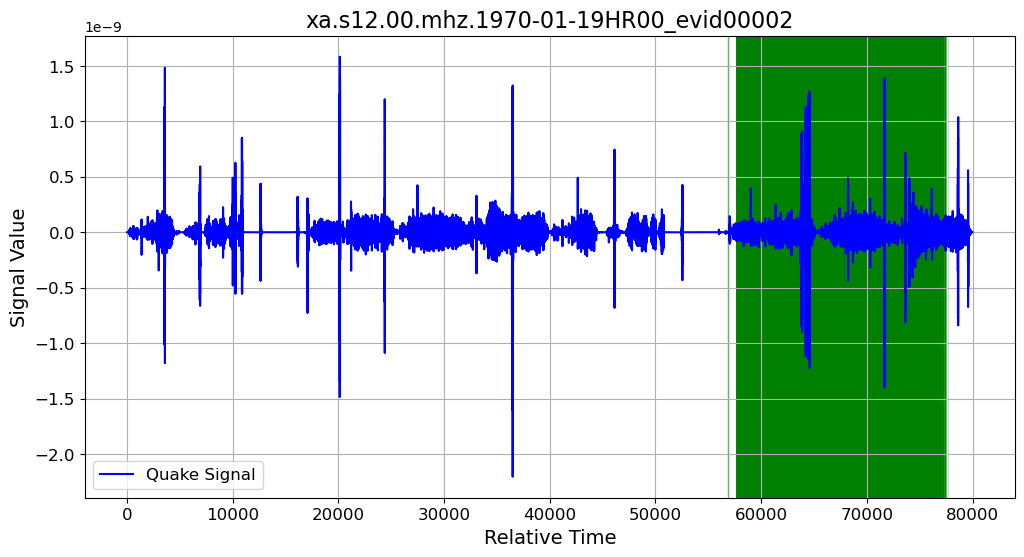

/home/angshukdutta/anaconda3/envs/space_apps/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


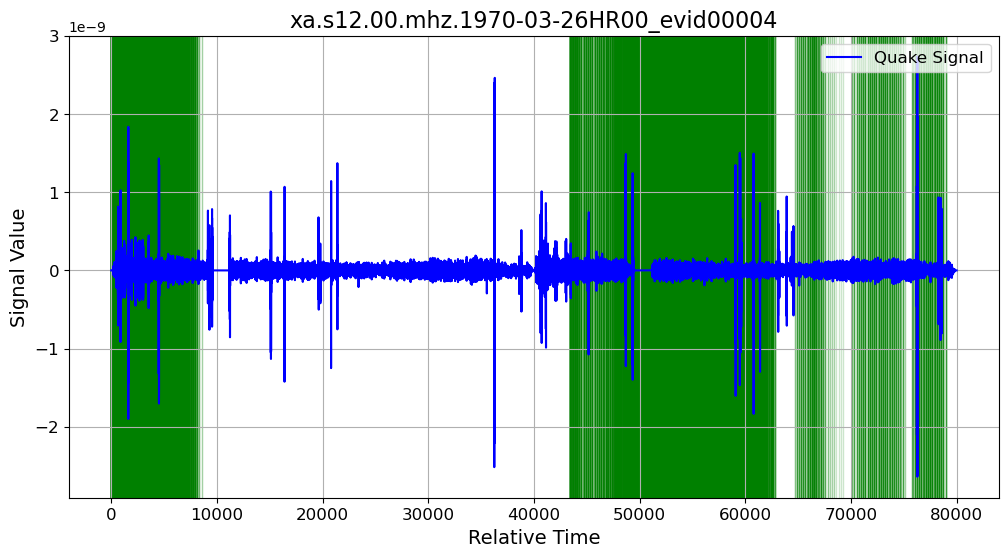

In [534]:
for i in moon_filenames:
    if i in seismic_dict_test['filename']:
#     if i not in seismic_dict_mars['filename']:
#         not_there.append(i)
#         continue
    

        index = seismic_dict_test['filename'].index(i)
        vel = seismic_dict_test['velocity'][index]
        
    else: 
        index = seismic_dict_mars['filename'].index(i)
        vel = seismic_dict_mars['velocity'][index]
    
    remainder = vel.shape[-1]%200
    reshape_value = vel.shape[-1]-remainder

    vel_truc = vel[:reshape_value]
    
    vel_truc_reshaped = torch.tensor(vel_truc.reshape(200, reshape_value//200))
    
    if vel_truc_reshaped.shape[-1]<200:
        vel_truc_reshaped = torch.cat((vel_truc_reshaped, torch.zeros(size=(200, 200 - vel_truc_reshaped.shape[-1]))), dim=-1)
    
    
    windowed_vel_truc = sliding_window(vel_truc_reshaped.unsqueeze(0), 200)
    
    input_signals = torch.cat((windowed_vel_truc))
    
    save_filter_img(input_signals, i)
    
    
    


In [373]:
from sklearn.cluster import KMeans

IndexError: The shape of the mask [81] at index 0 does not match the shape of the indexed tensor [2, 50, 50] at index 0

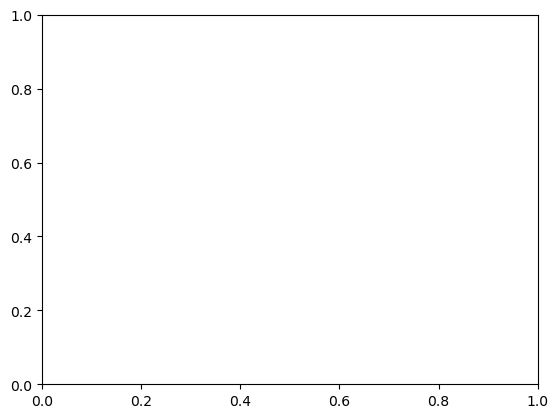

In [395]:
value = scat_dict[0]
value

value  = torch.cat(value)
# value.shape
N_CLUSTERS = 2
cluster_model = KMeans(n_clusters=N_CLUSTERS)
predictions = cluster_model.fit_predict(value.view(value.shape[1], value.shape[0]*value.shape[2]*value.shape[3]).cpu().detach())

# show clustering results in the atlas
fig, ax = plt.subplots()
for label in np.unique(predictions):
    where = label == predictions
    ax.scatter(value[where,0], value[where,1],s=1)
ax.set_aspect('equal')


In [276]:
################ save_model###########################
input_dim = 200
times_list = []
for i in range(len(concatenated_data_dict['arrival_time'])):
    times_list.append(concatenated_data_dict['arrival_time'][i]/len(concatenated_data_dict['time_list'][i]))

concatenated_data_dict['arrival_time_normalised'] = times_list


/tmp/ipykernel_15976/3278092672.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(values, shade=True)


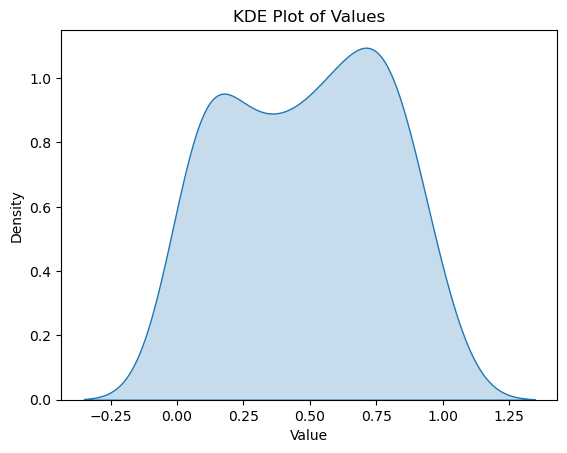

In [277]:
######### KDE plot #################
import seaborn as sns

values  = concatenated_data_dict['arrival_time_normalised']

sns.kdeplot(values, shade=True)

# Display the plot
plt.title("KDE Plot of Values")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

In [325]:
#### lin_reg_training_params #####
lr = 0.001
epoch_lin = 100
batch_size_lin = 10

### Model ####
model_lin = torch.nn.Linear(input_dim, 1).to(device)
model_lin_2 = torch.nn.Sequential(torch.nn.Linear(input_dim, 100), 
                                  torch.nn.ReLU(), torch.nn.Linear(100, 50)).to(device)


optim_lin = torch.optim.Adam(model_lin_2.parameters(), lr = lr)
loss  = torch.nn.MSELoss()

model_scattering = model_scattering.to(device)



In [324]:
train_indices = random.sample([i for i in range(len(concatenated_data_dict['filename']))], int(0.9*len(concatenated_data_dict['filename'])))
test_indices = list(set([i for i in range(len(concatenated_data_dict['filename']))]).difference(set(train_indices)))

train_data_arr = Quake(concatenated_data_dict, train_indices, window_len = window_len)
test_data_arr = Quake(concatenated_data_dict, test_indices, window_len)

train_dl = DataLoader(train_data_arr, batch_size = batch_size_lin, shuffle=True, collate_fn= collate_fn)
test_dl = DataLoader(test_data_arr, batch_size = batch_size_lin, shuffle=True, collate_fn=collate_fn)

epoch_loss_list = []; epoch_val_loss_list = []
for epoch in range(epoch_lin):
    model_lin.train()
    loss_list = []; 
    for idx, (vel_data,  arrival_time, mq_type, arrival_time_norm) in tqdm(enumerate(train_dl), total = len(train_dl)):
        zscored_vel_data = zscore(vel_data).float()
        windowed_data = sliding_window(zscored_vel_data, window_size = 200)
        pred_list = []
        for wind_data in windowed_data:
            with torch.no_grad():
                scat_coefficient_data = model_scattering(wind_data.contiguous().unsqueeze(1).to(device))
            
            pred = model_lin_2(scat_coefficient_data)
            pred_list.append(pred)
            
        pred_tens = torch.cat((pred_list), dim=-1)
        pred_mean = torch.abs(torch.mean(pred_tens, dim = -1))
        train_loss = loss(pred_mean, arrival_time_norm.float().to(device))
        optim_lin.zero_grad()
        train_loss.backward()
        
        optim.step()
        
        loss_list.append(train_loss.cpu().detach().item())
    
    epoch_loss_list.append(np.mean(loss_list))
    print(f'epoch: {epoch}, train_loss: {epoch_loss_list[epoch]}')
    
    val_loss_list = []; 

    for idx, (vel_data,  arrival_time, mq_type, arrival_time_norm) in tqdm(enumerate(test_dl), total = len(train_dl)):
        print(mq_type)
        model_lin.eval()
        zscored_vel_data_val = zscore(vel_data).float()
        windowed_data_val = sliding_window(zscored_vel_data_val, window_size = 200)
        pred_list_val = []
        for wind_data in windowed_data_val:
            
            with torch.no_grad():
                scat_coefficient_data = model_scattering(wind_data.contiguous().unsqueeze(1).to(device))
            
            pred_val = model_lin(scat_coefficient_data)
            pred_list_val.append(pred_val)
            
        pred_tens_val = torch.cat((pred_list_val), dim =-1)
        pred_mean_val = torch.abs(torch.mean(pred_tens_val, dim=-1))
        
        print(f'this is pred: {pred_mean_val} and this is true: {arrival_time_norm}')
        test_loss = loss(pred_mean_val, arrival_time_norm.float().to(device))
        val_loss_list.append(test_loss.cpu().detach().item())
        
    epoch_val_loss_list.append(np.mean(val_loss_list))
    print(f'epoch: {epoch}, test_loss: {epoch_val_loss_list[epoch]}')

    
        

        
        
        

    
    
        
        
        
            

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]


epoch: 0, train_loss: 15.843250138419014


 14%|███████████████████████████████▎                                                                                                                                                                                           | 1/7 [00:00<00:00, 11.70it/s]


[1, 2, 2, 3, 3, 2, 2, 2]
this is pred: tensor([27.4461, 23.6841, 23.4578, 23.6684, 24.7796, 24.3121, 23.1203, 25.5979],
       device='cuda:0', grad_fn=<AbsBackward0>) and this is true: tensor([0.0361, 0.5347, 0.3611, 0.3021, 0.3875, 0.9729, 0.5930, 0.2125],
       dtype=torch.float64)
epoch: 0, test_loss: 582.278564453125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.14it/s]


epoch: 1, train_loss: 16.43910993848528


 14%|███████████████████████████████▎                                                                                                                                                                                           | 1/7 [00:00<00:00, 11.49it/s]


[1, 2, 3, 2, 2, 2, 3, 2]
this is pred: tensor([27.9235, 23.9275, 24.1250, 24.7852, 23.5717, 26.0945, 25.2522, 24.1555],
       device='cuda:0', grad_fn=<AbsBackward0>) and this is true: tensor([0.0361, 0.3611, 0.3021, 0.9729, 0.5930, 0.2125, 0.3875, 0.5347],
       dtype=torch.float64)
epoch: 1, test_loss: 605.2158813476562


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.63it/s]


epoch: 2, train_loss: 17.225839614868164


 14%|███████████████████████████████▎                                                                                                                                                                                           | 1/7 [00:00<00:00, 12.15it/s]


[3, 2, 2, 1, 2, 2, 3, 2]
this is pred: tensor([24.5865, 24.0364, 24.6467, 28.4266, 25.2657, 26.6124, 25.7241, 24.4198],
       device='cuda:0', grad_fn=<AbsBackward0>) and this is true: tensor([0.3021, 0.5930, 0.5347, 0.0361, 0.9729, 0.2125, 0.3875, 0.3611],
       dtype=torch.float64)
epoch: 2, test_loss: 629.3241577148438


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.69it/s]


epoch: 3, train_loss: 17.93250138419015


 14%|███████████████████████████████▎                                                                                                                                                                                           | 1/7 [00:00<00:00, 12.60it/s]


[3, 2, 2, 2, 1, 2, 3, 2]
this is pred: tensor([25.0548, 24.5089, 24.9273, 27.1402, 28.9680, 25.1483, 26.1907, 25.7517],
       device='cuda:0', grad_fn=<AbsBackward0>) and this is true: tensor([0.3021, 0.5930, 0.3611, 0.2125, 0.0361, 0.5347, 0.3875, 0.9729],
       dtype=torch.float64)
epoch: 3, test_loss: 654.4934692382812


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.63it/s]


epoch: 4, train_loss: 18.73523575919015


 14%|███████████████████████████████▎                                                                                                                                                                                           | 1/7 [00:00<00:00, 11.72it/s]


[2, 2, 2, 3, 2, 2, 3, 1]
this is pred: tensor([27.6642, 25.4358, 26.2455, 26.6565, 25.6506, 24.9804, 25.5296, 29.5462],
       device='cuda:0', grad_fn=<AbsBackward0>) and this is true: tensor([0.2125, 0.3611, 0.9729, 0.3875, 0.5347, 0.5930, 0.3021, 0.0361],
       dtype=torch.float64)
epoch: 4, test_loss: 680.4896850585938


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.62it/s]


epoch: 5, train_loss: 19.51957212175642


 14%|███████████████████████████████▎                                                                                                                                                                                           | 1/7 [00:00<00:00, 11.21it/s]


[2, 3, 2, 2, 2, 1, 2, 3]
this is pred: tensor([28.1795, 26.0143, 25.9339, 26.1498, 25.4487, 30.1456, 26.7497, 27.1273],
       device='cuda:0', grad_fn=<AbsBackward0>) and this is true: tensor([0.2125, 0.3021, 0.3611, 0.5347, 0.5930, 0.0361, 0.9729, 0.3875],
       dtype=torch.float64)
epoch: 5, test_loss: 707.1522216796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.95it/s]


epoch: 6, train_loss: 20.30895451136998


 14%|███████████████████████████████▎                                                                                                                                                                                           | 1/7 [00:00<00:00, 11.82it/s]


[2, 2, 3, 1, 2, 2, 3, 2]
this is pred: tensor([28.6839, 26.4196, 26.5065, 30.7402, 27.2600, 26.6501, 27.6084, 25.9159],
       device='cuda:0', grad_fn=<AbsBackward0>) and this is true: tensor([0.2125, 0.3611, 0.3021, 0.0361, 0.9729, 0.5347, 0.3875, 0.5930],
       dtype=torch.float64)
epoch: 6, test_loss: 734.2908935546875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.12it/s]


epoch: 7, train_loss: 21.149428503853933


 14%|███████████████████████████████▎                                                                                                                                                                                           | 1/7 [00:00<00:00, 11.93it/s]


[2, 2, 3, 2, 3, 2, 2, 1]
this is pred: tensor([29.1871, 26.8995, 28.0992, 27.1536, 27.0074, 27.7661, 26.3831, 31.3223],
       device='cuda:0', grad_fn=<AbsBackward0>) and this is true: tensor([0.2125, 0.3611, 0.3875, 0.5347, 0.3021, 0.9729, 0.5930, 0.0361],
       dtype=torch.float64)
epoch: 7, test_loss: 761.9144287109375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.27it/s]


epoch: 8, train_loss: 21.987605231148855


 14%|███████████████████████████████▎                                                                                                                                                                                           | 1/7 [00:00<00:00, 11.53it/s]


[2, 3, 1, 2, 3, 2, 2, 2]
this is pred: tensor([27.6599, 28.6004, 31.9020, 27.3801, 27.5144, 26.8544, 29.6899, 28.2609],
       device='cuda:0', grad_fn=<AbsBackward0>) and this is true: tensor([0.5347, 0.3875, 0.0361, 0.3611, 0.3021, 0.5930, 0.2125, 0.9729],
       dtype=torch.float64)
epoch: 8, test_loss: 790.115478515625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.31it/s]


epoch: 9, train_loss: 22.89256341116769


 14%|███████████████████████████████▎                                                                                                                                                                                           | 1/7 [00:00<00:00, 11.48it/s]


[3, 2, 2, 2, 2, 2, 1, 3]
this is pred: tensor([28.0220, 28.1679, 28.7532, 27.8613, 27.3365, 30.1914, 32.4810, 29.1019],
       device='cuda:0', grad_fn=<AbsBackward0>) and this is true: tensor([0.3021, 0.5347, 0.9729, 0.3611, 0.5930, 0.2125, 0.0361, 0.3875],
       dtype=torch.float64)
epoch: 9, test_loss: 818.8895263671875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.79it/s]


epoch: 10, train_loss: 23.703450884137833


 14%|███████████████████████████████▎                                                                                                                                                                                           | 1/7 [00:00<00:00, 11.30it/s]


[2, 3, 3, 2, 2, 2, 2, 1]
this is pred: tensor([28.3483, 28.5287, 29.5967, 30.6919, 27.8331, 29.2493, 28.6805, 33.0568],
       device='cuda:0', grad_fn=<AbsBackward0>) and this is true: tensor([0.3611, 0.3021, 0.3875, 0.2125, 0.5930, 0.9729, 0.5347, 0.0361],
       dtype=torch.float64)
epoch: 10, test_loss: 848.2897338867188


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]


epoch: 11, train_loss: 24.706364222935267


 14%|███████████████████████████████▎                                                                                                                                                                                           | 1/7 [00:00<00:00, 11.14it/s]


[3, 1, 3, 2, 2, 2, 2, 2]
this is pred: tensor([29.0396, 33.6264, 30.0866, 31.1881, 29.7479, 28.3419, 28.8477, 29.2013],
       device='cuda:0', grad_fn=<AbsBackward0>) and this is true: tensor([0.3021, 0.0361, 0.3875, 0.2125, 0.9729, 0.5930, 0.3611, 0.5347],
       dtype=torch.float64)
epoch: 11, test_loss: 878.366455078125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]


epoch: 12, train_loss: 25.59793336050851


  0%|                                                                                                                                                                                                                                   | 0/7 [00:00<?, ?it/s]


[2, 1, 3, 2, 2, 2, 2, 3]


KeyboardInterrupt: 

In [288]:
model_scattering.to(device)

Sequential(
  (0): ParametricScattering2D(
    (params_filters): ParameterList(
        (0): Parameter containing: [torch.float32 of size 16 (cuda:0)]
        (1): Parameter containing: [torch.float32 of size 16 (cuda:0)]
        (2): Parameter containing: [torch.float32 of size 16 (cuda:0)]
        (3): Parameter containing: [torch.float32 of size 16 (cuda:0)]
    )
    (params_filters_phi): ParameterList(
        (0): Parameter containing: [torch.float32 of size 1 (cuda:0)]
        (1): Parameter containing: [torch.float32 of size 1 (cuda:0)]
        (2): Parameter containing: [torch.float32 of size 1 (cuda:0)]
        (3): Parameter containing: [torch.float32 of size 1 (cuda:0)]
    )
  )
  (1): View()
  (2): BatchNorm2d(81, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): View()
  (4): Linear(in_features=202500, out_features=200, bias=True)
)